In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nassimadif05","key":"cc981bfba492119128c5aed48eb7d4c8"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# 2. Set permissions
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
 97% 754M/778M [00:02<00:00, 257MB/s]
100% 778M/778M [00:02<00:00, 356MB/s]


In [ ]:
!unzip covid19-radiography-database.zip -d covid19_radiography

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: covid19_radiography/COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: covid19_radiography/COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: covid19_radiography/COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: covid19_radiography/COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: covid19_radiography/COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: covid19_radiography/COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: covid19_radiography/COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: covid19_radiography/COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: covid19_radiography/COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: covid19_radiography/COVID-19_Radiography_Dataset/Normal/masks/Normal-793

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!unzip -q covid19-radiography-database.zip -d /content/drive/MyDrive/Formation_doctorants/covid19_radiography

In [ ]:
import tensorflow as tf


# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU is available. Using GPU for training.")
    for gpu in tf.config.list_physical_devices('GPU'):
        print(f"  GPU: {gpu}")
else:
    print("GPU is not available. Using CPU for training.")

# Show TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

Num GPUs Available:  1
GPU is available. Using GPU for training.
  GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
TensorFlow version: 2.18.0


In [ ]:
import os

base_path = '/content/covid19_radiography/COVID-19_Radiography_Dataset'
for root, dirs, files in os.walk(base_path):
    print(root)

/content/covid19_radiography/COVID-19_Radiography_Dataset
/content/covid19_radiography/COVID-19_Radiography_Dataset/COVID
/content/covid19_radiography/COVID-19_Radiography_Dataset/COVID/masks
/content/covid19_radiography/COVID-19_Radiography_Dataset/COVID/images
/content/covid19_radiography/COVID-19_Radiography_Dataset/Viral Pneumonia
/content/covid19_radiography/COVID-19_Radiography_Dataset/Viral Pneumonia/masks
/content/covid19_radiography/COVID-19_Radiography_Dataset/Viral Pneumonia/images
/content/covid19_radiography/COVID-19_Radiography_Dataset/Lung_Opacity
/content/covid19_radiography/COVID-19_Radiography_Dataset/Lung_Opacity/masks
/content/covid19_radiography/COVID-19_Radiography_Dataset/Lung_Opacity/images
/content/covid19_radiography/COVID-19_Radiography_Dataset/Normal
/content/covid19_radiography/COVID-19_Radiography_Dataset/Normal/masks
/content/covid19_radiography/COVID-19_Radiography_Dataset/Normal/images


In [ ]:
import os
import cv2
import numpy as np

IMG_SIZE = (160, 160)  # Smaller size to reduce memory footprint
DATASET_DIR = '/content/covid19_radiography/COVID-19_Radiography_Dataset'
CLASSES = ['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity']

image_paths = []
labels = []

for idx, cls in enumerate(CLASSES):
    img_folder = os.path.join(DATASET_DIR, cls, 'images')
    for fname in os.listdir(img_folder):
        if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
            path = os.path.join(img_folder, fname)
            image_paths.append(path)
            labels.append(idx)

image_paths = np.array(image_paths)
labels = np.array(labels)

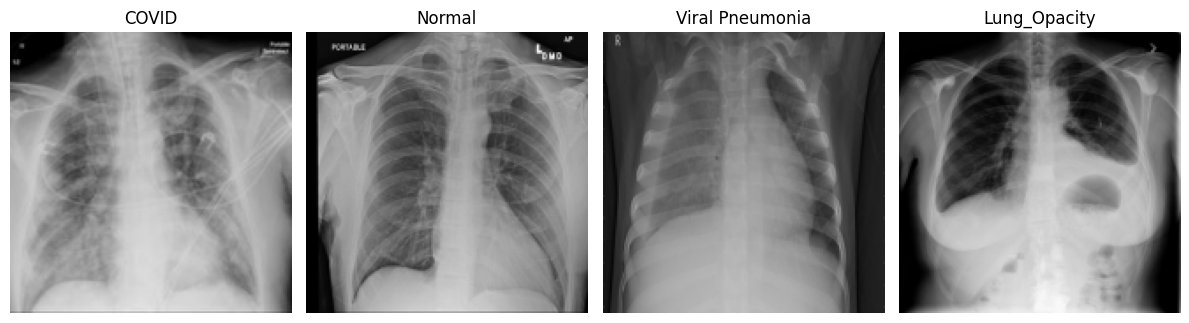

In [ ]:
#print some samples from the dataset
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

IMG_SIZE = (160, 160)
CLASSES = ['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity']

# Dictionary to store one sample image per class
sampled_images = {}

# Iterate through all image paths and find one image for each class
for path, label in zip(image_paths, labels):
    if label not in sampled_images:
        img = cv2.imread(path)
        img = cv2.resize(img, IMG_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        sampled_images[label] = img
    if len(sampled_images) == len(CLASSES):
        break

# Plot the samples
plt.figure(figsize=(12, 4))
for i, label in enumerate(sampled_images):
    plt.subplot(1, len(CLASSES), i + 1)
    plt.imshow(sampled_images[label])
    plt.title(CLASSES[label])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

train_paths, val_paths, y_train, y_val = train_test_split(
    image_paths, labels,
    test_size=0.3,
    stratify=labels,
    random_state=42
)
#The function to_categorical() is used to convert class labels (integers) into one-hot encoded vectors,
y_train_cat = to_categorical(y_train, len(CLASSES))
y_val_cat = to_categorical(y_val, len(CLASSES))

In [ ]:
from tensorflow.keras.utils import Sequence

class ImageSequence(Sequence):
    def __init__(self, image_paths, labels, batch_size=64, augment=False):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.augment = augment

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_images = []
        for path in batch_paths:
            img = cv2.imread(path)
            img = cv2.resize(img, IMG_SIZE)
            img = img / 255.0  # Normalize
            batch_images.append(img)

        return np.array(batch_images), np.array(batch_labels)

train_gen = ImageSequence(train_paths, y_train_cat, batch_size=32)
val_gen = ImageSequence(val_paths, y_val_cat, batch_size=32)


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers

base_model = MobileNetV2(input_shape=(160, 160, 3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.models import Model

def build_model(trainable_layers):
    base_model.trainable = False
    if trainable_layers > 0:
        for layer in base_model.layers[-trainable_layers:]:
            layer.trainable = True

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dense(512, activation='relu')(x)
    output = layers.Dense(len(CLASSES), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model


In [ ]:
model = build_model(0)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 4,096,580 (15.63 MB)

 Trainable params: 1,838,596 (7.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


463/463 ━━━━━━━━━━━━━━━━━━━━ 74s 136ms/step - accuracy: 0.7985 - loss: 0.5627 - val_accuracy: 0.8123 - val_loss: 0.5317
Epoch 2/5
463/463 ━━━━━━━━━━━━━━━━━━━━ 54s 117ms/step - accuracy: 0.8865 - loss: 0.3090 - val_accuracy: 0.8573 - val_loss: 0.3872
Epoch 3/5
463/463 ━━━━━━━━━━━━━━━━━━━━ 56s 121ms/step - accuracy: 0.9161 - loss: 0.2239 - val_accuracy: 0.8713 - val_loss: 0.3702
Epoch 4/5
463/463 ━━━━━━━━━━━━━━━━━━━━ 53s 115ms/step - accuracy: 0.9274 - loss: 0.1921 - val_accuracy: 0.8932 - val_loss: 0.3327
Epoch 5/5
463/463 ━━━━━━━━━━━━━━━━━━━━ 52s 113ms/step - accuracy: 0.9395 - loss: 0.1597 - val_accuracy: 0.8835 - val_loss: 0.3437
199/199 ━━━━━━━━━━━━━━━━━━━━ 22s 97ms/step

===== Report: Last_2_Conv_FC_Layers =====
                 precision    recall  f1-score   support

          COVID       0.86      0.91      0.88      1085
         Normal       0.91      0.89      0.90      3058
Viral Pneumonia       0.98      0.91      0.94       403
   Lung_Opacity       0.84      0.85      0.8

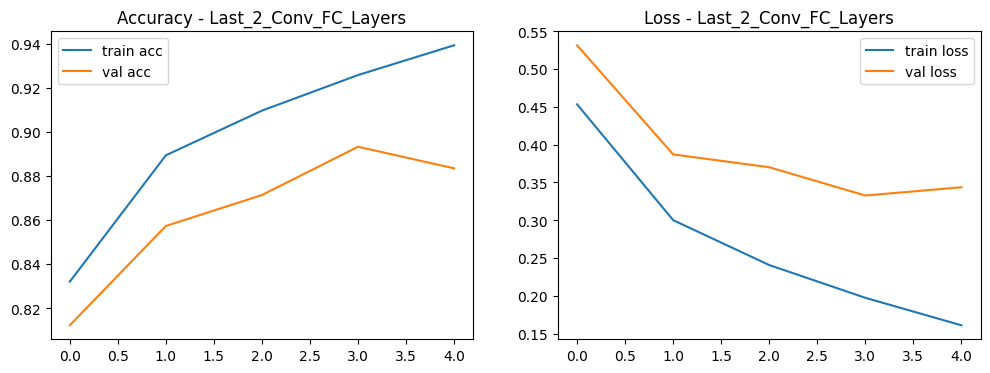

Training time: 289.96 seconds

Model saved to saved_models/covid_xray_classifier_last_2_conv_fc_layers.h5


In [ ]:
import time
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import os

# Create a directory to save models if it doesn't exist
os.makedirs("saved_models", exist_ok=True)

def train_strategy(trainable_layers, name):
    model = build_model(trainable_layers)
    model.compile(optimizer=optimizers.Adam(0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    start = time.time()
    history = model.fit(train_gen,
                        validation_data=val_gen,
                        epochs=5,
                        verbose=1)
    end = time.time()

    y_pred = model.predict(val_gen)
    y_true = np.argmax(y_val_cat, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)

    print(f"\n===== Report: {name} =====")
    print(classification_report(y_true, y_pred_classes, target_names=CLASSES))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.title(f'Accuracy - {name}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title(f'Loss - {name}')
    plt.legend()

    plt.show()
    print(f"Training time: {end - start:.2f} seconds\n")

    # Save the model
    model_filename = f"saved_models/covid_xray_classifier_{name.replace(' ', '_').lower()}.h5"
    model.save(model_filename)
    print(f"Model saved to {model_filename}")

    return model, history

# Train with different strategies and save each model
model_2conv, history_2conv = train_strategy(2, "Last_2_Conv_FC_Layers")
#model_1conv, history_1conv = train_strategy(1, "Last_1_Conv_FC_Layers")
#model_fc, history_fc = train_strategy(0, "Only_FC_Layers")


Model loaded successfully.


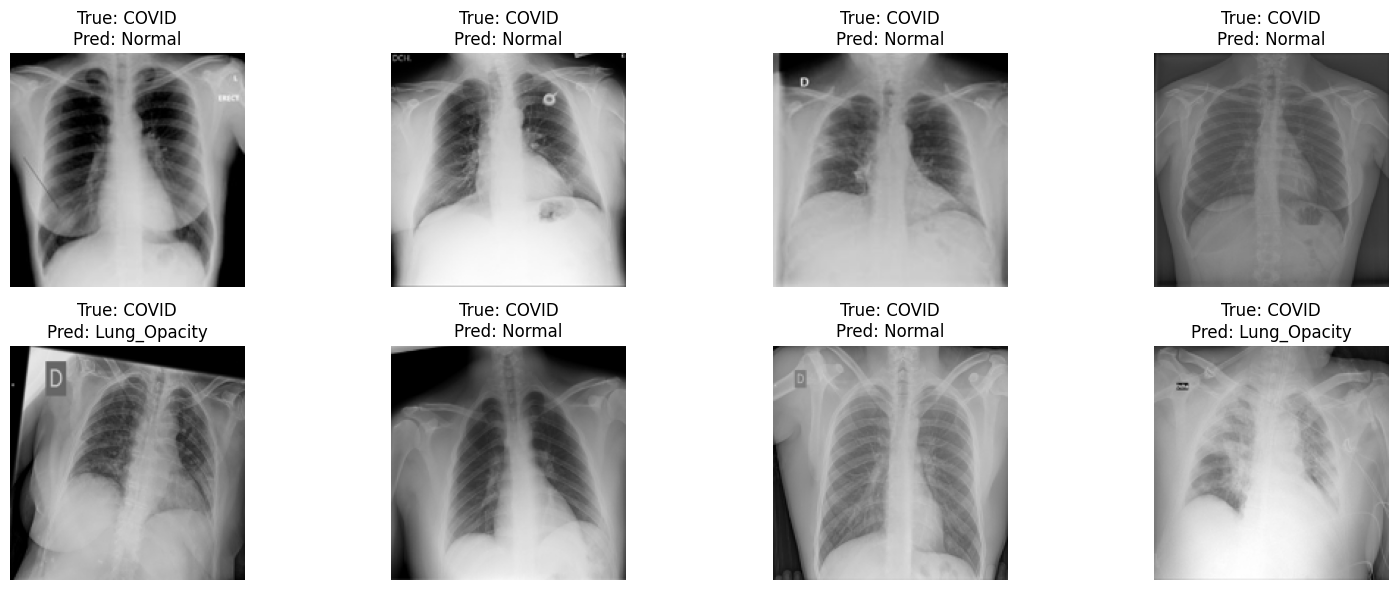

In [ ]:
from tensorflow.keras.models import load_model

# Constants
IMG_SIZE = (160, 160)
CLASSES = ['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity']
model_path = "/content/saved_models/covid_xray_classifier_last_2_conv_fc_layers.h5"

# Load model
model = load_model(model_path)
print("Model loaded successfully.")

def preprocess_image(path, img_size=(160, 160)):
    img = cv2.imread(path)
    img = cv2.resize(img, img_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype('float32') / 255.0
    return img

# Load image paths and labels
image_paths = []
labels = []

DATASET_DIR = "/content/covid19_radiography/COVID-19_Radiography_Dataset"
for idx, cls in enumerate(CLASSES):
    img_folder = os.path.join(DATASET_DIR, cls, 'images')
    for fname in os.listdir(img_folder):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join(img_folder, fname)
            image_paths.append(path)
            labels.append(idx)

image_paths = np.array(image_paths)
labels = np.array(labels)

# Find mispredicted samples
mispredicted = []

for path, true_label in zip(image_paths, labels):
    img = preprocess_image(path)
    input_img = np.expand_dims(img, axis=0)
    prediction = model.predict(input_img, verbose=0)
    pred_label = np.argmax(prediction)
    if pred_label != true_label:
        mispredicted.append((path, true_label, pred_label))
    if len(mispredicted) >= 8:
        break  # Only collect first 8 mispredictions

# Plot mispredicted samples
if mispredicted:
    plt.figure(figsize=(16, 6))
    for i, (path, true_label, pred_label) in enumerate(mispredicted):
        img = preprocess_image(path)
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.title(f"True: {CLASSES[true_label]}\nPred: {CLASSES[pred_label]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No mispredictions found in the current sample.")